In [1]:
import tensorflow as tf
import numpy as np
import os
import sys

In [2]:
# Path para importacion de funciones
dir_actual    = os.path.abspath('')
dir_parent = os.path.dirname(dir_actual)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading CIFAR10 Data

In [3]:
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalizando
x_test = x_test/255.
# Reducing Target innecessary dimension
y_test  = np.squeeze(y_test)

## Creating Dataset Objects

In [4]:
from functions import to_categorical, VGG_resize

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.map(VGG_resize)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

In [5]:
from models import VGG16_body

input_layer   = tf.keras.Input((224,224,3))
output_layer  = VGG16_body(input_layer, Quantization = False)

#For this example we using 8 bits of precision.
Qinput_layer  = tf.keras.Input((224,224,3))
Qoutput_layer = VGG16_body(Qinput_layer, Quantization = True, word_size = 14, frac_size = 8)

VGG16  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
QVGG16 = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [6]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

VGG16.load_weights(Wgt_dir)
QVGG16.load_weights(Wgt_dir)

## Quantize weights

In [7]:
from models import Weight_Quantization
Weight_Quantization(model = QVGG16, Frac_Bits = 8, Int_Bits = 5)

## Checking the model predictions

In [8]:
import time
import matplotlib.pyplot as plt

# Iterator over test Dataset
iterator  = iter(test_dataset)

Target: 8
Prediction: 8
QPrediction: 8


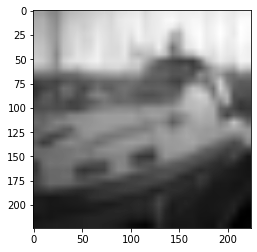

In [11]:
# Getting new image from iterator
image     = next(iterator)
image_plt = image[0][0,...,0]

# Plotting Test image
plt.imshow(image_plt, cmap='gray')

# Target
tf.print("Target:",np.argmax(image[1]))
# Predicted Output
print("Prediction:",np.argmax(VGG16.predict(image[0])))
# Quantized Predicted Output
print("QPrediction:",np.argmax(QVGG16.predict(image[0])))

## Comparation of Output

In [12]:
VGG16.predict(image[0])

array([[0.08497677, 0.10910951, 0.06963544, 0.02689659, 0.01240212,
        0.00185533, 0.00752872, 0.00320693, 0.6674999 , 0.01688874]],
      dtype=float32)

In [13]:
QVGG16.predict(image[0])

array([[0.09375   , 0.109375  , 0.078125  , 0.0234375 , 0.01171875,
        0.        , 0.0078125 , 0.00390625, 0.6484375 , 0.015625  ]],
      dtype=float32)

#### Classes

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

## Check the general Accuracy

In [14]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
VGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QVGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
VGG16.evaluate(test_dataset)

10000/10000 [==============================] - 141s 14ms/step - loss: 0.8012 - accuracy: 0.7349


[0.8012385272836876, 0.7349]

In [20]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 172s 17ms/step - loss: 0.8922 - accuracy: 0.7359


[0.8922459922850597, 0.7359]

## Checking The Output of Each Layer

In [15]:
from functions import get_all_outputs
# List for layer names.

Layer_Names = []
for layer in VGG16.layers:
    Layer_Names.append(layer.name)

QLayer_Names = []
for layer in QVGG16.layers:
    QLayer_Names.append(layer.name)
    
# Dictionary with layer name -> outputs
Layers_Outputs  = dict(zip(Layer_Names, get_all_outputs(VGG16,image[0])))
QLayers_Outputs = dict(zip(QLayer_Names, get_all_outputs(QVGG16,image[0])))

## Comparing Outputs for The convolution #3

In [16]:
Layers_Outputs

{'input_1': array([[[[0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          ...,
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ]],
 
         [[0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          ...,
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ]],
 
         [[0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          ...,
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ]],
 
         ...,
 
         [[0.10980392, 0.16078432, 0.18431373],
       

In [17]:
QLayers_Outputs

{'input_2': array([[[[0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          ...,
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ]],
 
         [[0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          ...,
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ]],
 
         [[0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          [0.61960787, 0.74509805, 0.87058824],
          ...,
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ],
          [0.93333334, 0.94509804, 0.9647059 ]],
 
         ...,
 
         [[0.10980392, 0.16078432, 0.18431373],
       

## Testing Max and Min Values of Each Layer for the original model

In [31]:
N_layers  = len(QVGG16.layers)
iterator  = iter(test_dataset)
image     = next(iterator,'Stop')
Max_values = [0]*N_layers
Min_values = [0]*N_layers
while image != 'Stop':
    Model_outputs = get_all_outputs(VGG16,image[0])
    Max_iteration_values = np.array([np.max(itm) for itm in Model_outputs])
    Min_iteration_values = np.array([np.min(itm) for itm in Model_outputs])
    Max_values = np.maximum(Max_values, Max_iteration_values)
    Min_values = np.minimum(Min_values, Min_iteration_values)
    image = next(iterator,'Stop')

In [32]:
Max_values

array([ 1.        ,  1.        ,  0.55289382,  0.55289382,  0.55289382,
        0.55289382,  0.56202006,  0.56202006,  0.56202006,  0.56202006,
        0.56202006,  0.40619522,  0.40619522,  0.40619522,  0.40619522,
        0.57603204,  0.57603204,  0.57603204,  0.57603204,  0.57603204,
        0.672952  ,  0.672952  ,  0.672952  ,  0.672952  ,  1.06780303,
        1.06780303,  1.06780303,  1.06780303,  1.74278188,  1.74278188,
        1.74278188,  1.74278188,  1.74278188,  1.6580162 ,  1.6580162 ,
        1.6580162 ,  1.6580162 ,  1.94520521,  1.94520521,  1.94520521,
        1.94520521,  2.26748776,  2.26748776,  2.26748776,  2.26748776,
        2.26748776,  2.46216726,  2.46216726,  2.46216726,  2.46216726,
        3.3225956 ,  3.3225956 ,  3.3225956 ,  3.3225956 ,  3.02389812,
        3.02389812,  3.02389812,  3.02389812,  3.02389812,  3.02389812,
        4.39980793,  4.39980793,  4.39980793,  4.39980793,  4.64638805,
        4.64638805,  4.64638805,  4.64638805, 44.03063965, 44.03

In [33]:
Min_values

array([  0.        ,   0.        ,  -0.67023152,  -0.67023152,
         0.        ,   0.        ,  -0.55003768,  -0.55003768,
         0.        ,   0.        ,   0.        ,  -0.65099853,
        -0.65099853,   0.        ,   0.        ,  -0.53201503,
        -0.53201503,   0.        ,   0.        ,   0.        ,
        -0.66176283,  -0.66176283,   0.        ,   0.        ,
        -0.94754082,  -0.94754082,   0.        ,   0.        ,
        -1.39863992,  -1.39863992,   0.        ,   0.        ,
         0.        ,  -1.55851161,  -1.55851161,   0.        ,
         0.        ,  -2.03468847,  -2.03468847,   0.        ,
         0.        ,  -3.00645447,  -3.00645447,   0.        ,
         0.        ,   0.        ,  -3.01076388,  -3.01076388,
         0.        ,   0.        ,  -3.67845058,  -3.67845058,
         0.        ,   0.        ,  -5.63244438,  -5.63244438,
         0.        ,   0.        ,   0.        ,   0.        ,
        -5.26455212,  -5.26455212,   0.        ,   0.  

## Checking max and min values of weights

In [8]:
for itm in VGG16.get_weights():
    print(np.max(itm))

0.105967745
0.014988257
0.09595051
0.011936342
0.10281713
0.015564269
0.08596791
0.019136881
0.09624452
0.012335057
0.07714346
0.012018733
0.067087404
0.011228289
0.07069143
0.016360529
0.08120797
0.021275712
0.07580003
0.018184675
0.0711499
0.036662944
0.07354726
0.033380628
0.06902299
0.032600958
0.064379156
0.026954189
0.071879946
0.03205061
0.053636953
0.011063661


In [9]:
for itm in VGG16.get_weights():
    print(np.min(itm))

-0.115536876
-0.016275147
-0.10245023
-0.016122118
-0.08389944
-0.017848462
-0.087104104
-0.017060434
-0.08118384
-0.014572672
-0.0745357
-0.011928877
-0.074435614
-0.012825207
-0.07202102
-0.014688623
-0.06944868
-0.013372264
-0.083173715
-0.03949675
-0.07473356
-0.02615708
-0.07346563
-0.036137845
-0.07589335
-0.040974997
-0.07180178
-0.015379306
-0.06817566
-0.014832148
-0.07294732
-0.011839713
